In [1]:
import numpy as np
import pandas as pd
#from tqdm import tqdm
#from keras import backend as K
from scipy.signal import resample
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
import random
import time
import gc
import spafe



In [ ]:
import vggish_params
from mel_features import log_mel_spectrogram
from tensorflow.keras.callbacks import CSVLogger

num_ceps = 13
low_freq = 20
high_freq = 4000
nfilts = 24
nfft = 512
dct_type = 2,
use_energy = False,
lifter = 5
normalize = True


In [2]:

from scipy.io import wavfile
import matplotlib.pyplot as plt
import wavio
import zipfile

In [3]:
from spafe.features.rplp import rplp, plp
from spafe.features.gfcc import gfcc
from spafe.features.mfcc import mfcc
from spafe.features.ngcc import ngcc
from spafe.features.lfcc import lfcc
from spafe.features.bfcc import bfcc
from spafe.features.msrcc import msrcc
from spafe.features.psrcc import psrcc
from spafe.features.lpc import lpc, lpcc
from spafe.utils import vis
import mel_features

In [4]:
from joblib import Parallel, delayed
import multiprocessing
import time
num_cores = multiprocessing.cpu_count()
print(num_cores)

8


In [7]:
%%time


z = zipfile.ZipFile("../../train_fs.zip", "r") ##训练集
fn_list = z.namelist()
def get_wav(fn):
    content = z.read(fn)
    with open('./tmp.wav','wb') as f:
        f.write(content)
    w =  wavio.read('./tmp.wav')
    return w.rate ,w.data.reshape(w.data.shape[0])

L = 51200
y_train = []
x_train = []
new_sample_rate = 4000
fn_list =[i for i in fn_list if 'wav' in i]
train_fn = [i for i in fn_list if 'dev' not in i and 'wav' in i]
dev_fn = [i for i in fn_list if 'dev'  in i]
print(len(fn_list),len(train_fn),len(dev_fn))

for fname in  train_fn:
    try:
        #samples, sample_rate = sf.read(fname )
        #samples = samples*32768
        sample_rate, samples = get_wav(fname)
        if sample_rate!=16000:
            print(fname)
    except:
        continue
    label = int( fname.split('/')[-1].split('-')[0][2:])
    x_train.append(samples)
    y_train.append(label)
print(len(x_train),len(y_train))

y_dev = []
x_dev = []
for fname in  dev_fn:
    try:
        sample_rate, samples = get_wav(fname)
    except:
        continue
    label = int( fname.split('/')[-1].split('-')[0][2:])
    x_dev.append(samples)
    y_dev.append(label)
print(len(x_dev),len(y_dev))

12320 4976 7344
4863 4863
7344 7344
CPU times: user 26 s, sys: 5.15 s, total: 31.1 s
Wall time: 6min 7s


In [9]:
%%time
z = zipfile.ZipFile("../../test_fs.zip", "r") ##测试集
fn_list = z.namelist()
def get_wav(fn):
    content = z.read(fn)
    with open('./tmp.wav','wb') as f:
        f.write(content)
    w =  wavio.read('./tmp.wav')
    return w.rate ,w.data.reshape(w.data.shape[0])
x_test = []
test_fn = [i for i in fn_list if 'test'  in i and 'wav' in i]

for fname in  test_fn:
    try:
        sample_rate, samples = get_wav(fname)
    except:
        continue
    x_test.append(samples)
print(len(x_test))

7541
CPU times: user 9.59 s, sys: 2.11 s, total: 11.7 s
Wall time: 2min 55s


(51200,)


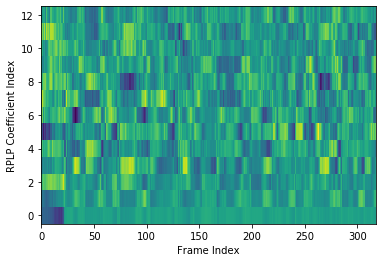

(318, 13)


In [10]:
print(x_dev[0].shape)
rplps = bfcc(x_dev[0], 16000, 13)
vis.visualize_features(rplps, 'RPLP Coefficient Index', 'Frame Index')
print(rplps.shape)

In [12]:
import random
L = 51200
lg_list = [len(i) for i in x_dev]


def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))


In [13]:
##随机打乱
idx=np.arange(len(x_train))  
np.random.shuffle(idx) 
x_train = [x_train[i]  for i in idx]
y_train = [y_train[i]  for i in idx]
print(len(x_train),len(y_train))

4863 4863


In [15]:

def get_feat(samples,method=bfcc):
    ###在提取特征后 用vggish思路分成3个0.96秒frame，不用结果稍差一点点
    method = m
    if method.__name__=='lpc'  or 'plp' in m.__name__ :
        samples = lpc(sig=samples, fs=16000, num_ceps=num_ceps)
    elif method.__name__ == 'log_mel_spectrogram':
        samples = log_mel_spectrogram(
          samples  ,
          audio_sample_rate=16000,
          log_offset=vggish_params.LOG_OFFSET,
          window_length_secs=vggish_params.STFT_WINDOW_LENGTH_SECONDS,
          hop_length_secs=vggish_params.STFT_HOP_LENGTH_SECONDS,
          num_mel_bins=40,
          lower_edge_hertz=20,
          upper_edge_hertz=4000)        
    elif method.__name__=='lpcc':
        samples = lpcc(sig=samples, fs=16000, num_ceps=num_ceps, lifter=0, normalize=True)
    else:
        samples = method(sig=samples,
             fs=16000,
             num_ceps=num_ceps,
             nfilts=nfilts,
             nfft=nfft,
             low_freq=low_freq,
             high_freq=high_freq,
             dct_type=dct_type,
             use_energy=use_energy,
             lifter=lifter,
             normalize=normalize)
    features_sample_rate = 1.0 / vggish_params.STFT_HOP_LENGTH_SECONDS
    example_window_length = int(round(
      vggish_params.EXAMPLE_WINDOW_SECONDS * features_sample_rate))
    example_hop_length = int(round(
      vggish_params.EXAMPLE_HOP_SECONDS * features_sample_rate))
    samples = mel_features.frame(
      samples,
      window_length=example_window_length,
      hop_length=example_hop_length)
    return samples.reshape((samples.shape[1],samples.shape[2],3))  

def get_dev_feat(data,method=bfcc,shape=(318, 13,1)):
    shape = m_shape
    num_features = 51200
    shape = (len(data),)+shape
    res_data = np.zeros(shape)

    for i in range(len(data)):
        d = data[i] #/32768
        tmp = np.zeros((res_data.shape[1:]))
        lg = 51200
        n = np.random.randint(0,num_features-lg+1)
        d = d[n:n+lg]
        samples = pad_audio(d)
        samples = samples-1 + 2*np.random.random(len(samples))

        spectrogram = get_feat(samples,method=method)
        res_data[i,:,:,:] = spectrogram 
    return res_data    
def get_train_feat(data,method=bfcc,shape=(318, 13,1)):
    shape = m_shape

    num_features = 51200
    #训练集随机截取五次
    num_iter = 5
    shape = (len(data)*5,)+shape

    res_data = np.zeros(shape)
    num = 0
    for i in range(len(data)):
        d = data[i] #/32768
        lg = 51200
        samples = pad_audio(d)
        samples = samples-1 + 2*np.random.random(len(samples))

        for i in range(num_iter):
            n = np.random.randint(0,len(samples)-lg+1)
            t_sample = samples[n:n+lg] 
            spectrogram = get_feat(t_sample,method=method)
            res_data[num,:,:,:] = spectrogram
            num+=1
        
    return res_data 


In [18]:
#训练集随机截取五次
y_train1 = []
for i in y_train:
    for n in range(5):
        y_train1.append(i)

In [19]:
def block(input,kernel_size=3):
    x0 = BatchNormalization()(input)

    x0 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x0)
    x0 = SpatialDropout2D(0.2)(x0)
    x0 = Masking(mask_value=0.0)(x0)
    x1 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x0)
    x1 = BatchNormalization()(x1)

    
    
    x2 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x1)
    x2 = x1+x2
    x2 = BatchNormalization()(x2)
    #shortcut = Conv2D(128, kernel_size=3, padding='same')(x2)

    
    x3 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x2)
    x3 = BatchNormalization()(x3)
    x4 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x3)
    x4 = x3+x4+x2
    x4 = BatchNormalization()(x4)    
    
    n_maps = 128
    x4 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x4)
    x4 = BatchNormalization()(x4)   
    
    x5 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x4)
    x5 = BatchNormalization()(x5)
    x6 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x5)
    x6 = x5+x6+x4
    x6 = BatchNormalization()(x6)   
    
    n_maps = 128
    x6 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x6)
    x6 = BatchNormalization()(x6)   
    
    x7 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x6)
    x7 = BatchNormalization()(x7)
    x8 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x7)
    x8 = x7+x8+x6
    x8 = BatchNormalization()(x8)   
    
    x9 = Conv2D(filters=n_maps, kernel_size=kernel_size, activation='relu', padding='same')(x8)
    x9 = BatchNormalization()(x9)    
    x = GlobalAveragePooling2D()(x9)
    return x


def Net(shape=(158, 40,1)):
        #input_plp = Input(shape= (326, 13,1))
        #input_mel =  Input(shape= (158, 40,1))
        input = Input(shape=shape)
        xx1 = block(input,kernel_size=3)  

        #xx2 = block(input,kernel_size=5)    
        #x = Concatenate()([xx1,xx2])
        x = Dense(20, activation='softmax')(xx1)
        model = Model([input], x)
        return model

In [20]:
##参考开源任意epochs下学习率

from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import backend as K
import numpy as np
import argparse
 
 
parser = argparse.ArgumentParser()
parser.add_argument('--lr_decay_epochs', type=list, default=[12, 18, 25], help="For MultiFactorScheduler step")
parser.add_argument('--lr_decay_factor', type=float, default=0.1)
args, _ = parser.parse_known_args()
 
 
def get_lr_scheduler(args):
    lr_scheduler = MultiStepLR(args=args)
    return lr_scheduler
 
 
class MultiStepLR(Callback):
    """Learning rate scheduler.
    Arguments:
        args: parser_setting
        verbose: int. 0: quiet, 1: update messages.
    """
 
    def __init__(self, args, verbose=0):
        super(MultiStepLR, self).__init__()
        self.args = args
        self.steps = args.lr_decay_epochs
        self.factor = args.lr_decay_factor
        self.verbose = verbose
 
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.schedule(epoch)
        if not isinstance(lr, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        K.set_value(self.model.optimizer.lr, lr)
        print("learning rate: {:.7f}".format(K.get_value(self.model.optimizer.lr)).rstrip('0'))
        if self.verbose > 0:
            print('\nEpoch %05d: MultiStepLR reducing learning '
                  'rate to %s.' % (epoch + 1, lr))
 
    def schedule(self, epoch):
        lr = K.get_value(self.model.optimizer.lr)
        for i in range(len(self.steps)):
            if epoch == self.steps[i]:
                lr = lr * self.factor
 
        return lr

lr_scheduler = get_lr_scheduler(args=args)


In [21]:

def train(x_train,y_train,x_dev,y_dev,log_fn='log.csv',shape=(158, 40,1),model_fn = '../model/model_mel_valid.h5',lr=False):

    csv_logger = CSVLogger(log_fn, append=True, separator=',')


    model = Net(shape=shape)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=["acc"])

    plateau = ReduceLROnPlateau(monitor="val_acc",
                                verbose=0,
                                mode='max',
                                factor=0.1,
                                patience=3)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=0,
                                   mode='max',
                                   patience=7)
    checkpoint = ModelCheckpoint(model_fn,
                                 monitor='val_acc',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    if lr == False:
        model.fit(x_train, to_categorical(np.array(y_train)-1,num_classes=20),
                  epochs=100,
                  batch_size=64,
                  verbose=1,
                  shuffle=True,
                  validation_data=(x_dev, to_categorical( np.array(y_dev)-1,num_classes=20)),
                  callbacks=[early_stopping, checkpoint,plateau,csv_logger]) 
    else:
        model.fit(x_train, to_categorical(np.array(y_train)-1,num_classes=20),
                  epochs=100,
                  batch_size=32,
                  verbose=1,
                  shuffle=True,
                  validation_data=(x_dev, to_categorical( np.array(y_dev)-1,num_classes=20)),
                  callbacks=[early_stopping,plateau ,checkpoint,csv_logger,lr_scheduler]) 
    return model.predict(x_dev)

In [22]:
###多线程构造特征
def get_data(x,way=get_dev_feat):
    n = int(len(x)/100)  +1

    tmp=Parallel(n_jobs=num_cores)( 
                delayed(way)(d)
                for d in [x[i*100:(i+1)*100]  for i in range(n)     ])
    tmp = np.vstack(tmp)
    return tmp

In [ ]:
##由于机器限制未采用5折交叉验证的方式训练

In [ ]:
method_list = [lpc,rplp,lpcc,plp,log_mel_spectrogram, mfcc,gfcc,bfcc,ngcc,lfcc]
method_list.reverse()
pred_list = []
p_list = []
for e in range(1):
    for m in method_list: 
        print(m)

        if 'lpc' in m.__name__ or 'plp' in m.__name__ : 
            m_shape = (96,13,3)
            x_dev_tmp = get_data(x_dev,get_dev_feat)
            x_test_tmp = get_data(x_test,get_dev_feat)
            x_train_tmp = get_data(x_train,get_train_feat) 
        elif 'log_mel_spectrogram' ==  m.__name__:
            m_shape = (96,40,3)
            x_dev_tmp = get_data(x_dev,get_dev_feat)
            x_test_tmp = get_data(x_test,get_dev_feat)
            x_train_tmp = get_data(x_train,get_train_feat) 
        else:
            m_shape = (96,13,3)
            x_dev_tmp = get_data(x_dev,get_dev_feat)
            x_test_tmp = get_data(x_test,get_dev_feat)
            x_train_tmp = get_data(x_train,get_train_feat) 


        
        x_train_tmp = np.vstack([x_train_tmp,x_dev_tmp,x_dev_tmp])
        y_train_tmp =y_train1+y_dev+y_dev
        #y_train_tmp =y_train1
        idx=np.arange(len(x_train_tmp))  
        np.random.shuffle(idx) 
        x_train_tmp = x_train_tmp[idx]
        y_train_tmp = [y_train_tmp[i]  for i in idx]

        name = f'pred{e}_'+m.__name__
        locals()[name] = train(x_train_tmp,y_train_tmp,x_dev_tmp,y_dev,\
                         log_fn='log_online.csv',shape=x_train_tmp.shape[1:],model_fn = f'../model/model_{m.__name__}_3chh_{e}.h5',lr=True
                         )
        p_list.append(locals()[name])
        
        
        pred = np.argmax(locals()[name],axis=1)
        pred_max = np.max(locals()[name],axis=1)
        index_list = [num for num, i in enumerate(pred_max) if i>0.998]
        print(len(index_list))

        x_train_tmp = np.vstack([x_train_tmp,x_test_tmp[index_list]])
        y_train_tmp =y_train_tmp+[pred[n]+1 for n in index_list  ]

        idx=np.arange(len(x_train_tmp))  
        np.random.shuffle(idx) 
        x_train_tmp = x_train_tmp[idx]
        y_train_tmp = [y_train_tmp[i]  for i in idx]

        name = f'pred{e}_'+m.__name__
        locals()[name] = train(x_train_tmp,y_train_tmp,x_dev_tmp,y_dev,\
                         log_fn='log_v1.csv',shape=x_train_tmp.shape[1:],model_fn = f'../model/model_{m.__name__}_3chhh_{e}.h5',lr=True
                         )
        pred_list.append(locals()[name])

<function ngcc at 0x7faf603a6158>
Train on 39003 samples, validate on 7344 samples
learning rate: 0.001
Epoch 1/100
39003/39003 [==============================] - 73s 2ms/sample - loss: 2.2218 - acc: 0.3081 - val_loss: 2.4527 - val_acc: 0.2791
learning rate: 0.001
Epoch 2/100
39003/39003 [==============================] - 60s 2ms/sample - loss: 1.5027 - acc: 0.5236 - val_loss: 1.9153 - val_acc: 0.4144
learning rate: 0.001
Epoch 3/100
39003/39003 [==============================] - 60s 2ms/sample - loss: 1.1137 - acc: 0.6435 - val_loss: 1.0614 - val_acc: 0.6484
learning rate: 0.001
Epoch 4/100
16064/39003 [===========>..................] - ETA: 32s - loss: 0.8670 - acc: 0.7169

In [ ]:
pred = np.argmax(p_list,axis=1)+1 #原始训练模型结果

pred = np.argmax(pred_list,axis=1)+1   #伪标签训练结果

sub = pd.read_csv('../../提交样例.csv')
sub['label'] = ['L0'+str(i).zfill(2) for i in pred]
sub.to_csv('../sub/tf_model_sub.csv',index=None)
sub['label'].value_counts()
